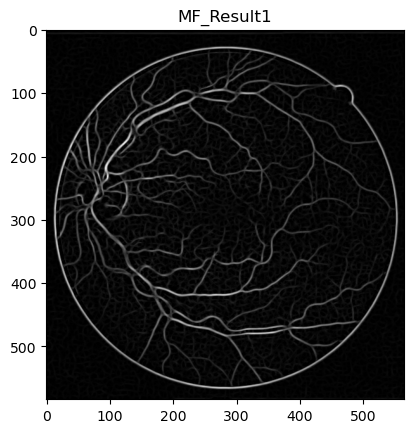

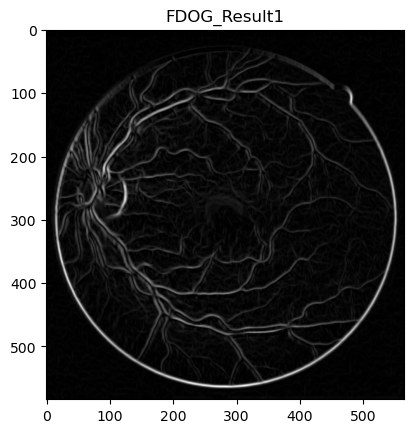

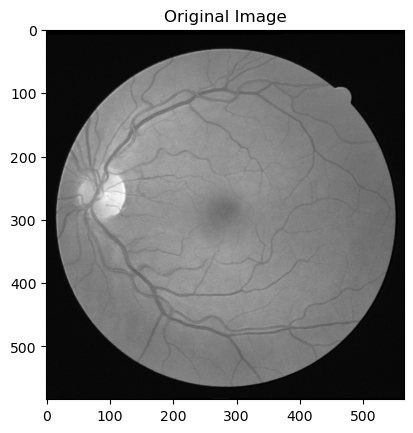

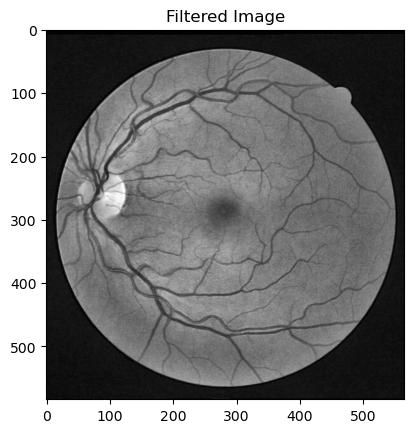

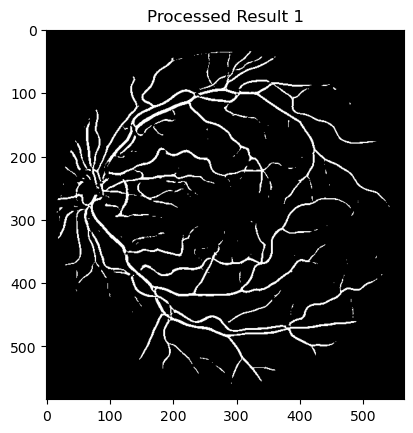

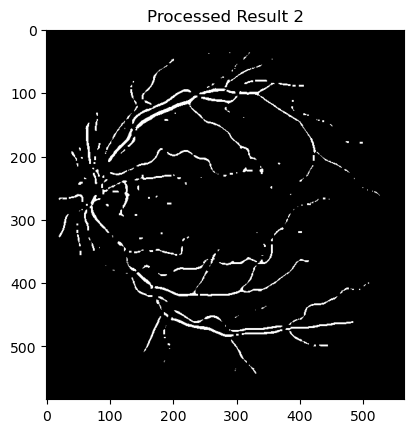

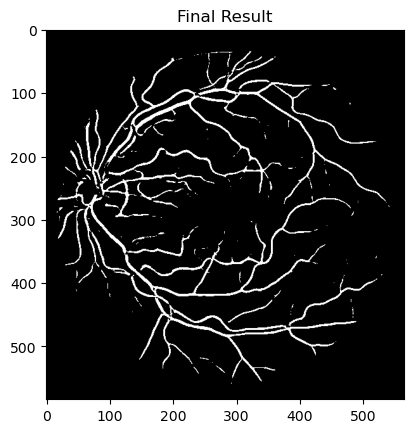

Accuracy: 93.48915020002426
True Positive Rate (TPR): 0.637972841901067
False Positive Rate (FPR): 0.008349607428958591
Specificity: 0.9916503925710414
Sensitivity: 0.637972841901067


In [3]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from skimage.morphology import disk, white_tophat


def load_image(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def load_ground_truth(path):
    return cv2.imread(path, cv2.IMREAD_GRAYSCALE)


def create_mask(img, threshold=40):
    im_mask = img > threshold
    im_mask = cv2.erode(im_mask.astype(img.dtype), cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3, 3)))
    return im_mask


def display_image(img, title):
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.show()


def preprocess_image(image_path):
    image = cv2.imread(image_path)
    blue_channel, green_channel, red_channel = cv2.split(image)
    green_channel_extraction = green_channel.copy()
    negative_transform = 255 - green_channel_extraction
    selem = disk(30)
    white_tophat_transform = white_tophat(negative_transform, selem)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    clahe_transformed = clahe.apply(green_channel)
    return clahe_transformed


def apply_filter(img, kernel):
    return cv2.filter2D(img, cv2.CV_64F, kernel)


def get_width(sigma, YLength):
    arg_square_root = (6 * np.ceil(sigma) + 1) ** 2 + YLength ** 2
    sqrt_result = np.sqrt(arg_square_root)
    rounded_up = np.ceil(sqrt_result)
    rounded_up_int = int(rounded_up)
    width_of_kernel = rounded_up_int + 1 if rounded_up_int % 2 == 0 else rounded_up_int
    return width_of_kernel


def integrate_normal_distribution(t, s):
    x_range = np.arange(-t * s, t * s + 1)
    normal_distribution = np.exp(-0.5 * (x_range / s) ** 2) / (np.sqrt(2 * np.pi) * s)
    integral_result = np.sum(normal_distribution) / (2 * t * s)
    return integral_result


def calculate_rotated_coordinates(x, y, theta):
    X = x * np.cos(theta) + y * np.sin(theta)
    Y = x * np.sin(theta) - y * np.cos(theta)
    return X, Y


def MF_Filter(s, L, angle, t, filter_width):
    h = (filter_width - 1) // 2
    MF_knl = np.zeros((filter_width, filter_width))

    for i in range(-h, h + 1):
        for j in range(-h, h + 1):
            X, Y = calculate_rotated_coordinates(j, i, angle)
            if not (np.abs(X) > t * s or np.abs(Y) > (L - 1) / 2):
                MF_knl[i + h, j + h] = (-1 / (np.sqrt(2 * np.pi) * s)) * np.exp(
                    -0.5 * X ** 2 / s ** 2)
    MF_knl = apply_mean_value_correction(MF_knl)
    return MF_knl


def apply_mean_value_correction(MF_knl):
    mean_value = np.sum(MF_knl[MF_knl < 0]) / np.sum(MF_knl < 0)
    for i in range(MF_knl.shape[0]):
        for j in range(MF_knl.shape[1]):
            if MF_knl[i, j] < 0:
                MF_knl[i, j] -= mean_value

    return MF_knl


def FDOG_Filter(s, L, angle, t, filter_width):
    h = (filter_width - 1) // 2
    FDOG_knl = np.zeros((filter_width, filter_width))

    for i in range(-h, h + 1):
        for j in range(-h, h + 1):
            X, Y = calculate_rotated_coordinates(j, i, angle)
            if not (np.abs(X) > t * s or np.abs(Y) > (L - 1) / 2):
                FDOG_knl[i + h, j + h] = (-X / (
                        np.sqrt(2 * np.pi) * s ** 3)) * np.exp(-0.5 * X ** 2 / s ** 2)

    return FDOG_knl


def get_D_H(img, s, L, t, num_of_directions, W_size=31, c_factor=2.3):
    r, c = img.shape
    MF_List = [[0 for _ in range(c)] for _ in range(r)]
    FDOG_List = [[0 for _ in range(c)] for _ in range(r)]

    for i in range(num_of_directions):
        angle = (np.pi / num_of_directions) * i
        MF_knl = MF_Filter(s, L, angle, t,
                                        get_width(s, L))
        FDOG_knl = FDOG_Filter(s, L, angle, t,
                                              get_width(s, L))
        match_filter_res_i = apply_filter(img, MF_knl)
        gauss_derivative_res_i = apply_filter(img, FDOG_knl)

        for row in range(r):
            for col in range(c):
                MF_List[row][col] = max(MF_List[row][col], match_filter_res_i[row][col])
                FDOG_List[row][col] = max(FDOG_List[row][col], gauss_derivative_res_i[row][col])
    H = np.array(MF_List)
    D = np.array(FDOG_List)

    return H, D


def final_processing(H, D, img, W_size=31, c_factor=2.3):
    W = np.ones((W_size, W_size)) / (W_size * W_size)
    Dm = apply_filter(D, W)
    Dm = (Dm - np.min(Dm)) / (np.max(Dm) - np.min(Dm))
    muH = np.mean(H)
    Tc = c_factor * muH
    T = (1 + Dm) * Tc
    Mh = H >= T
    im_mask = create_mask(img)
    Mh = cv2.bitwise_and(Mh.astype(img.dtype), im_mask)
    return Mh


def calculate_tpr_fpr(processed_image, ground_truth):
    if processed_image.shape != ground_truth.shape:
        raise ValueError("Images must have the same shape")

    TP = np.sum((processed_image == 1) & (ground_truth == 255))
    FP = np.sum((processed_image == 1) & (ground_truth == 0))
    TN = np.sum((processed_image == 0) & (ground_truth == 0))
    FN = np.sum((processed_image == 0) & (ground_truth == 255))

    TPR = TP / (TP + FN) if (TP + FN) > 0 else 0
    FPR = FP / (FP + TN) if (FP + TN) > 0 else 0

    return TPR, FPR


def calculate_specificity(TN, FP):
    return TN / (TN + FP) if (TN + FP) > 0 else 0


def calculate_sensitivity(TP, FN):
    return TP / (TP + FN) if (TP + FN) > 0 else 0


def calculate_accuracy(TP, TN, FP, FN):
    return (TP + TN) / (TP + FN + TP + FP) if (TP + FN + TP + FP) > 0 else 0


def calculate_confusion_matrix(processed_image, ground_truth):
    if processed_image.shape != ground_truth.shape:
        raise ValueError("Images must have the same shape")

    TP = np.sum((processed_image == 1) & (ground_truth == 255))
    FP = np.sum((processed_image == 1) & (ground_truth == 0))
    TN = np.sum((processed_image == 0) & (ground_truth == 0))
    FN = np.sum((processed_image == 0) & (ground_truth == 255))

    return TP, FP, TN, FN


def remove_salt_and_pepper_noise(img, filter_size):
    return cv2.medianBlur(img, filter_size)


# Load the image and ground truth
img_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\images\01_test.tif"
ground_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\vessel\01_test.png"
img_filtered = preprocess_image(img_path)  # Use the preprocessed image
ground_truth = load_ground_truth(ground_path)

# Apply MatchFilterWithGaussDerivative for the first set of parameters
MF_Result1, FDOG_Result1 = get_D_H(img_filtered, s=1.5, L=9, t=3,
                                   num_of_directions=8, W_size=31, c_factor=2.3)
display_image(MF_Result1, 'MF_Result1')
display_image(FDOG_Result1, 'FDOG_Result1')
result1 = final_processing(MF_Result1, FDOG_Result1, img_filtered)
# Apply MatchFilterWithGaussDerivative for the second set of parameters
MF_Result2, FDOG_Result2 = get_D_H(img_filtered, s=1, L=5, t=3,
                                   num_of_directions=8, W_size=31, c_factor=2.3)
result2 = final_processing(MF_Result2, FDOG_Result2, img_filtered)

# Perform bitwise OR operation
final_result = cv2.bitwise_or(result1, result2)


def calculate_accuracy(processed_image, ground_truth):
    if processed_image.shape != ground_truth.shape:
        raise ValueError("Images must have the same shape")

    correct_pixels = np.sum(processed_image == ground_truth)
    total_pixels = processed_image.size
    accuracy = (correct_pixels / total_pixels) * 100

    return accuracy


# Display the original and processed images side by side
img = load_image(img_path)
display_image(img, 'Original Image')
display_image(img_filtered, 'Filtered Image')  # Display filtered image
display_image(result1 * 255, 'Processed Result 1')
display_image(result2 * 255, 'Processed Result 2')

# Display the final result after bitwise OR operation
display_image(final_result * 255, 'Final Result')

# Calculate and print accuracy, TPR, FPR, Specificity, Sensitivity
TP, FP, TN, FN = calculate_confusion_matrix(final_result, ground_truth)
accuracy = calculate_accuracy(final_result, ground_truth)
tpr, fpr = calculate_tpr_fpr(final_result, ground_truth)
specificity = calculate_specificity(TN, FP)
sensitivity = calculate_sensitivity(TP, FN)

print(f'Accuracy: {accuracy}')
print(f"True Positive Rate (TPR): {tpr}")
print(f"False Positive Rate (FPR): {fpr}")
print(f"Specificity: {specificity}")
print(f"Sensitivity: {sensitivity}")

In [ ]:
# import os
# import cv2

# # Set the base paths for images and ground truth
# base_image_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\images"
# base_ground_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\vessel"

# # Set the range of image indices
# start_index = 1
# end_index = 20

# # Lists to store metrics for each image
# accuracy_list = []
# tpr_list = []
# fpr_list = []

# # Loop through the image indices
# for i in range(start_index, end_index + 1):
#     # Generate the file paths for the current iteration
#     img_path = os.path.join(base_image_path, f"{str(i).zfill(2)}_test.tif")
#     ground_path = os.path.join(base_ground_path, f"{str(i).zfill(2)}_test.png")

#     # Load the image and ground truth
#     img_filtered = preprocess_image(img_path)  # Use the preprocessed image
#     ground_truth = load_ground_truth(ground_path)

#     # Apply MF_Filter for the first set of parameters
#     MF_Result1, FDOG_Result1 = get_D_H(img_filtered, s=1.5, L=9, t=3, num_of_directions=8, W_size=31, c_factor=2.3)
#     result1 = final_processing(MF_Result1, FDOG_Result1, img_filtered)

#     # Apply MF_Filter for the second set of parameters
#     MF_Result2, FDOG_Result2 = get_D_H(img_filtered, s=1, L=5, t=3, num_of_directions=8, W_size=31, c_factor=2.3)
#     result2 = final_processing(MF_Result2, FDOG_Result2, img_filtered)

#     # Perform bitwise OR operation
#     final_result = cv2.bitwise_or(result1, result2)

#     # Calculate and append accuracy, TPR, FPR to the respective lists
#     TP, FP, TN, FN = calculate_confusion_matrix(final_result, ground_truth)
#     accuracy = calculate_accuracy(final_result, ground_truth)
#     tpr, fpr = calculate_tpr_fpr(final_result, ground_truth)

#     accuracy_list.append(accuracy)
#     tpr_list.append(tpr)
#     fpr_list.append(fpr)

# # Print the lists
# print("Accuracy List:", accuracy_list)
# print("TPR List:", tpr_list)
# print("FPR List:", fpr_list)
# avg_accuracy = np.mean(accuracy_list)
# avg_tpr = np.mean(tpr_list)
# avg_fpr = np.mean(fpr_list)

# # Print the averages
# print(f"Average Accuracy: {avg_accuracy}")
# print(f"Average TPR: {avg_tpr}")
# print(f"Average FPR: {avg_fpr}")


In [ ]:
# import os
# import cv2
# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.metrics import auc

# # Define your preprocess_image, load_ground_truth, match_filter_with_gauss_derivative,
# # final_processing, remove_salt_and_pepper_noise, load_image, calculate_confusion_matrix,
# # calculate_accuracy, calculate_tpr_fpr, calculate_specificity, calculate_sensitivity functions here

# # Set the base paths for images and ground truth
# base_image_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\images"
# base_ground_path = r"C:\Users\marki\Downloads\AV_ground\AV_groundTruth\test\vessel"

# # Lists to store metrics for each image
# accuracy_list = []
# tpr_list = []
# fpr_list = []
# def threshold_image(img, threshold):
#     img = np.where(img > threshold, 255, 0).astype(np.uint8)
#     return img

# # Loop through the image indices
# for i in range(1, 21):
#     # Generate the file paths for the current iteration
#     img_path = os.path.join(base_image_path, f"{str(i).zfill(2)}_test.tif")
#     ground_path = os.path.join(base_ground_path, f"{str(i).zfill(2)}_test.png")

#     # Load the image and ground truth
#     img_filtered = preprocess_image(img_path)  # Use the preprocessed image
#     ground_truth = load_ground_truth(ground_path)

#     # Apply MatchFilterWithGaussDerivative for the first set of parameters
#     im_mask = create_mask(img_filtered)

#     MF_Result1, FDOG_Result1 = get_D_H(img_filtered, s=1.5, L=9, t=3, num_of_directions=8, W_size=31, c_factor=2.3)
#     MF_Result1 = np.array(MF_Result1)

#     # Threshold the MF_Result1
#     threshold_value = 50
#     MF_Result1 = threshold_image(MF_Result1, threshold_value)

#     # Apply bitwise AND operation with the mask
#     im_mask = np.array(im_mask)
#     MF_Result1 = cv2.bitwise_and(MF_Result1.astype(np.uint8), im_mask.astype(np.uint8))

#     # Calculate and append accuracy, TPR, FPR to the respective lists
#     TP, FP, TN, FN = calculate_confusion_matrix(MF_Result1, ground_truth)
#     accuracy = calculate_accuracy(MF_Result1, ground_truth)
#     tpr, fpr = calculate_tpr_fpr(MF_Result1, ground_truth)

#     accuracy_list.append(accuracy)
#     tpr_list.append(tpr)
#     fpr_list.append(fpr)

# # Calculate the averages
# avg_accuracy = np.mean(accuracy_list)
# avg_tpr = np.mean(tpr_list)
# avg_fpr = np.mean(fpr_list)

# # Print the averages
# print(f"Average Accuracy for MF_Result1: {avg_accuracy}")
# print(f"Average TPR for MF_Result1: {avg_tpr}")
# print(f"Average FPR for MF_Result1: {avg_fpr}")
